In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mai 30

@author: yaning
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from scipy.ndimage import rotate

2025-09-19 22:13:42.834185: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 22:13:42.868682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 22:13:43.678253: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
# pick some numbers, rotate and train 1, for different number 2
one = x_train[23]
two = x_train[25]

In [6]:
y_train[25]

np.uint8(2)

In [7]:
one.shape

(28, 28, 1)

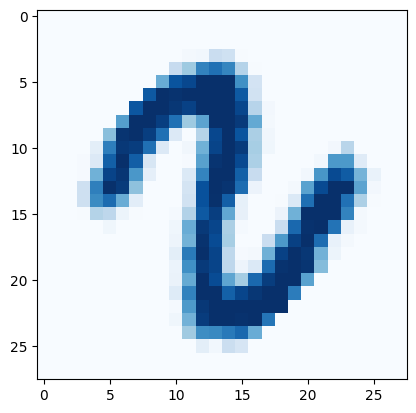

In [10]:
plt.imshow(rotated_img, cmap='Blues')

In [8]:
def rotate_only_pixel(img, angle):
    # Rotate only the non-zero pixels
    # 1. Find bounding box of non-zero pixels
    img = img.reshape(28,28)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # 2. Crop to bounding box
    cropped = img[rmin:rmax+1, cmin:cmax+1]

    # 3. Rotate cropped image
    rotated_cropped = rotate(cropped, angle=angle, reshape=True, order=1, mode='constant', cval=0)

    # 4. Place back into a zero array of original size
    rotated_img = np.zeros_like(img)
    rh, rw = rotated_cropped.shape
    # Compute start indices to center the rotated image
    start_r = (img.shape[0] - rh)//2
    start_c = (img.shape[1] - rw)//2
    rotated_img[start_r:start_r+rh, start_c:start_c+rw] = rotated_cropped

    rotated_img = rotated_img.reshape(28,28,1)
    
    return rotated_img


In [9]:
rotate_dataset = []
for i in range(10):
    rotate_dataset.append(rotate_only_pixel(two, i*10))

In [10]:
rotate_dataset = np.array(rotate_dataset)

In [11]:
rotate_dataset.shape

(10, 28, 28, 1)

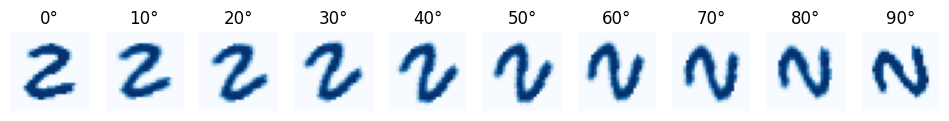

In [12]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(rotate_dataset[i], cmap='Blues')
    plt.title(f"{int(10*i)}°")
    plt.axis('off')
plt.show()

normalise them independently and also keep the 0/pure-black ones zeros

if not the zeros will be around 0.5 after normalisation but there should be no information at all

In [13]:
# only normalise non-zero ones 
def normalise_non_zero(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        non_zero_mask = img != 0
        img = img[non_zero_mask]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i][non_zero_mask] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

# normalise everything
def normalise(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

In [14]:
# size=7, sigma=2.0, Lambda=3.0, psi=0, gamma=0.5, theta=0
def gabor_kernel(size=4, sigma=4.0, Lambda=10.0, psi=0.5, gamma=1, theta=0):
    """Generate a 2D Gabor filter kernel."""
    half = size // 2
    y, x = np.meshgrid(range(-half, half+1), range(-half, half+1))
    x_theta = x * np.cos(theta) + y * np.sin(theta) + 1
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Generate 6 filters rotated from 0 to 360
angles = np.deg2rad(np.arange(0, 360, 45))
filters = np.stack([gabor_kernel(theta=angle) for angle in angles], axis=-1)  # shape (size, size, 6)

# Conv2D weights shape: (kernel_h, kernel_w, input_channels, output_channels)
filters = filters[:, :, np.newaxis, :]  # add input channel dim = 1

# Normalize filters to zero mean and unit norm (optional)
filters -= filters.mean(axis=(0,1), keepdims=True)
filters /= np.linalg.norm(filters, axis=(0,1), keepdims=True) + 1e-10

In [15]:
gabor_data = []
for pic in rotate_dataset:
    img = np.expand_dims(pic, axis=0)
    feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
    gabor_data.append(feature_maps[0])

I0000 00:00:1758312885.378144  780583 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22027 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-09-19 22:14:45.608836: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


In [16]:

img = np.expand_dims(one, axis=0)
feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
gabor_data.append(feature_maps[0])

In [17]:
gabor_data = np.array(gabor_data)

In [18]:
gabor_data.shape

(11, 10, 10, 8)

In [19]:
normalised_gabor_data = normalise_non_zero(gabor_data)

In [20]:
normalised_gabor_data.shape

(11, 10, 10, 8)

In [21]:
normalised_gabor_data = np.where(normalised_gabor_data > 0.5, 1, 0)

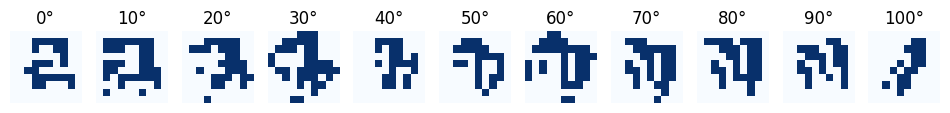

In [22]:
plt.figure(figsize=(12,3))
for i in range(11):
    plt.subplot(1,11,i+1)
    plt.imshow(normalised_gabor_data[i, :, :, 3], cmap='Blues')
    plt.title(f"{int(10*i)}°")
    plt.axis('off')
plt.show()

In [23]:
# normalised_gabor_data = normalised_gabor_data[:3]
normalised_gabor_data = np.concatenate((normalised_gabor_data[:2], normalised_gabor_data[-1:]))

In [25]:
normalised_gabor_data.shape

(3, 10, 10, 8)

In [26]:
# form an shape (5000, 3) array with 5000 time points and 3 input neurons
# every fire is 45-50 cycles, 
pointCount = 6000
start_tstep = 0
# one_cycle = np.concatenate((np.ones(45, dtype=bool), np.zeros(189, dtype=bool)))
one_cycle = np.ones(234)
firing_duration = 45+189
# 23*(45+189) = 5382
total_time = 5382


non_fire_array = np.zeros(pointCount, dtype=bool)

fire_seq = np.tile(one_cycle, 23)
fire_array = non_fire_array.copy()
fire_array[start_tstep:start_tstep+len(fire_seq)] = fire_seq

In [27]:
fire_data = np.zeros((3,10,10,8,600), dtype=bool)
for i in range(normalised_gabor_data.shape[0]):
    for x in range(normalised_gabor_data.shape[1]):
        for y in range(normalised_gabor_data.shape[2]):
            for z in range(normalised_gabor_data.shape[3]):
                if normalised_gabor_data[i,x,y,z] == 0:
                    fire_data[i,x,y,z] = non_fire_array[:600]
                else:
                    fire_data[i,x,y,z] = fire_array[:600]

In [28]:
fire_data = fire_data.reshape(10,10,8,1800)

In [29]:
import pickle
path = "/home/yaning/Documents/"

with open(path + "fire_data_gabor_binary_rotate.pkl", "wb") as f:
    pickle.dump(fire_data, f)